In [3]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, f1_score, confusion_matrix, accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE, ADASYN
from tensorflow.keras.utils import to_categorical
from sklearn.utils import class_weight
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv1D, MaxPooling1D, Softmax, Add, Flatten, Activation, Dropout, BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler

# Load and preprocess data
df = pd.read_csv('C:/Users/OJO ABAYOMI MOSES/Documents/ECG-detection-main/mitbih_train.csv', header=None)
df2 = pd.read_csv('C:/Users/OJO ABAYOMI MOSES/Documents/ECG-detection-main/mitbih_test.csv', header=None)
df = pd.concat([df, df2], axis=0)
df[187] = df[187].astype(int)

X = df.iloc[:, :-1]
y = df.iloc[:, -1].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True, stratify=y)

asy = ADASYN(random_state=42)
X_res, y_res = asy.fit_resample(X_train, y_train)

X_train = np.array(X_res)
X_test = np.array(X_test)
y_train = np.array(y_res)
y_test = np.array(y_test)

X_train = np.expand_dims(X_train, 2)
X_test = np.expand_dims(X_test, 2)

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Define shape parameters
n_obs, feature, depth = X_train.shape

# Clear previous session
K.clear_session()

# Define model architecture
inp = Input(shape=(feature, depth))

def residual_block(x, filters, kernel_size=5, strides=1):
    shortcut = x
    x = Conv1D(filters=filters, kernel_size=kernel_size, strides=strides, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv1D(filters=filters, kernel_size=kernel_size, strides=strides, padding='same')(x)
    x = BatchNormalization()(x)
    x = Add()([x, shortcut])
    x = Activation("relu")(x)
    return x

C = Conv1D(filters=64, kernel_size=5, strides=1, padding='same')(inp)
C = Activation("relu")(C)

# Stack multiple residual blocks
for _ in range(5):
    C = residual_block(C, filters=64)
    C = MaxPooling1D(pool_size=2, strides=2)(C)

# Flatten the output and add Dense layers
F1 = Flatten()(C)

D1 = Dense(128)(F1)
D1 = Activation("relu")(D1)
D1 = Dropout(0.5)(D1)  # Dropout for regularization

D2 = Dense(64)(D1)
D2 = Activation("relu")(D2)
D2 = Dropout(0.5)(D2)  # Dropout for regularization

D3 = Dense(5)(D2)
A7 = Softmax()(D3)

model = Model(inputs=inp, outputs=A7)
model.summary()

# Define learning rate schedule
def exp_decay(epoch):
    initial_lrate = 1e-4
    k = 0.1
    lrate = initial_lrate * math.exp(-k * epoch)
    return lrate

lrate = LearningRateScheduler(exp_decay)

# Compile the model
adam = Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999)

model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train,
                    epochs=200,
                    batch_size=512,
                    verbose=2,
                    validation_data=(X_test, y_test),
                    callbacks=[lrate])


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 187, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 187, 64)   │        384 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 187, 64)   │          0 │ conv1d[0][0]      │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 187, 64)   │     20,544 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 187, 64)   │        256 │ conv1d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 187, 64)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 187, 64)   │     20,544 │ activation_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 187, 64)   │        256 │ conv1d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 187, 64)   │          0 │ batch_normalizat… │
│                     │                   │            │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 187, 64)   │          0 │ add[0][0]         │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 93, 64)    │          0 │ activation_2[0][… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 93, 64)    │     20,544 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 93, 64)    │        256 │ conv1d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 93, 64)    │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 93, 64)    │     20,544 │ activation_3[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 93, 64)    │        256 │ conv1d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 93, 64)    │          0 │ batch_normalizat… │
│                     │                   │            │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 93, 64)    │          0 │ add_1[0][0]       │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 258,053 (1008.02 KB)

 Trainable params: 256,773 (1003.02 KB)

 Non-trainable params: 1,280 (5.00 KB)

Epoch 1/200
620/620 - 817s - 1s/step - accuracy: 0.6293 - loss: 1.0816 - val_accuracy: 0.2161 - val_loss: 1.5970 - learning_rate: 1.0000e-04
Epoch 2/200
620/620 - 654s - 1s/step - accuracy: 0.8850 - loss: 0.3451 - val_accuracy: 0.9302 - val_loss: 0.2182 - learning_rate: 9.0484e-05
Epoch 3/200
620/620 - 670s - 1s/step - accuracy: 0.9493 - loss: 0.1682 - val_accuracy: 0.9618 - val_loss: 0.1320 - learning_rate: 8.1873e-05
Epoch 4/200
620/620 - 745s - 1s/step - accuracy: 0.9714 - loss: 0.1014 - val_accuracy: 0.9509 - val_loss: 0.1687 - learning_rate: 7.4082e-05
Epoch 5/200
620/620 - 660s - 1s/step - accuracy: 0.9810 - loss: 0.0702 - val_accuracy: 0.9755 - val_loss: 0.1103 - learning_rate: 6.7032e-05
Epoch 6/200
620/620 - 708s - 1s/step - accuracy: 0.9860 - loss: 0.0527 - val_accuracy: 0.9597 - val_loss: 0.1640 - learning_rate: 6.0653e-05
Epoch 7/200
620/620 - 725s - 1s/step - accuracy: 0.9896 - loss: 0.0409 - val_accuracy: 0.9707 - val_loss: 0.1313 - learning_rate: 5.4881e-05
Epoch 8/200
6

KeyboardInterrupt: 

In [4]:
y_pred = model.predict(X_test, batch_size=1000)
print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))
print('Accuracy', accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1)))
#print('ROC AUC score:', roc_auc_score(y_test.argmax(axis=1), y_pred.argmax(axis=1)))
print('confusion matrix:')
print(confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1)))

33/33 ━━━━━━━━━━━━━━━━━━━━ 32s 793ms/step
              precision    recall  f1-score   support

           0       0.99      0.98      0.99     27177
           1       0.66      0.87      0.75       833
           2       0.96      0.94      0.95      2171
           3       0.66      0.88      0.75       241
           4       0.98      0.99      0.98      2412

    accuracy                           0.98     32834
   macro avg       0.85      0.93      0.89     32834
weighted avg       0.98      0.98      0.98     32834

Accuracy 0.975117256502406
confusion matrix:
[[26639   346    69    80    43]
 [   97   727     3     2     4]
 [   70    17  2050    28     6]
 [   16     1    12   212     0]
 [   17     4     2     0  2389]]


<Axes: >

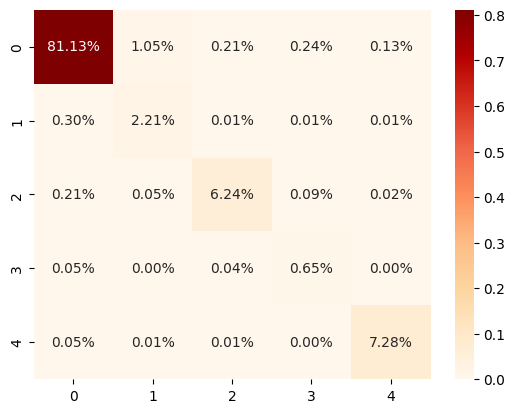

In [5]:
import seaborn as sns
cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='OrRd')

In [7]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('ACCURACY CURVE')
plt.legend(['accuracy','val_accuracy'], loc='best')
plt.show()

NameError: name 'history' is not defined

In [8]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('LOSS CURVE')
plt.legend(['loss','val_loss'], loc='best')
plt.show()

NameError: name 'history' is not defined

In [10]:
model.save(r'C:\Users\OJO ABAYOMI MOSES\3D Objects\cnnmodel.h5')
print('saved the model to disk')

saved the model to disk
